In [23]:
import os 
import tensorflow as tf
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

random_seed = 9292
torch.manual_seed(random_seed)
BATCH_SIZE = 256
NUM_EPOCHS = 1000
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)
lr = 3e-4
latent_dims = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
data_dir = './data'

transform = transforms.Compose([
    transforms.ToTensor()
])

training = MNIST(data_dir, train=True, transform=transform, download=True)
testing = MNIST(data_dir, train=False, transform=transform, download=True)

train_dataloader = DataLoader(training, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(training, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

torch.Size([1, 28, 28])


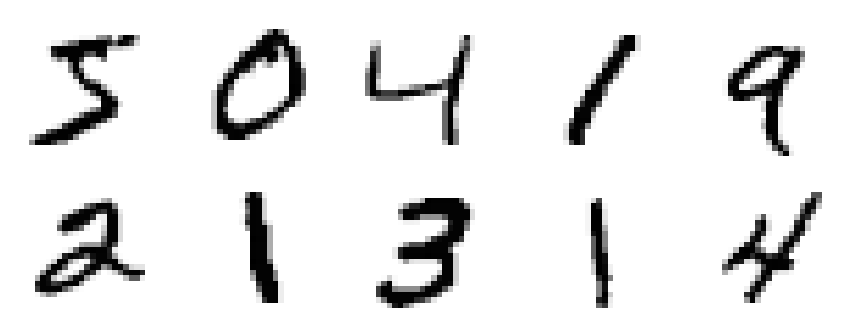

In [25]:
for data, _ in train_dataloader:
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        ax = axs[i//5, i%5]
        ax.imshow(data[i].permute(1,2,0), cmap='Greys')
        ax.axis('off')
        
    print(data[0].shape)
    break


plt.subplots_adjust(wspace=0.1, hspace=0)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2) # converts from 28x28 to 14x14
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2) # 7x7
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=2) # 3x3

        self.lin1 = nn.Linear(128, 100) 
        self.lin2 = nn.Linear(100, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.maxpool1(self.conv1(x)), inplace=False)
        x = F.leaky_relu((self.conv2(x)), inplace=False)

        x = x.view(-1, 128)
        x = F.leaky_relu(self.lin1(x), inplace=False)
        x = torch.sigmoid(self.lin2(x))
        return x

In [27]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 288)
        self.ct1 = nn.ConvTranspose2d(32, 8, kernel_size=5, stride=2)
        self.ct2 = nn.ConvTranspose2d(8, 4, kernel_size=5, stride=2)
        self.ct3 = nn.ConvTranspose2d(4, 2, kernel_size=3, stride=2)
        self.conv = nn.Conv2d(2, 1, kernel_size=16, stride=1)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))

        x = x.view(-1, 32, 3, 3)
        
        x = F.leaky_relu(self.ct1(x), inplace=False)
        x = F.leaky_relu(self.ct2(x), inplace=False)
        x = F.leaky_relu(self.ct3(x), inplace=False)

        return self.conv(x)

In [28]:
gen = Generator(latent_dims).to(device)
disc = Discriminator().to(device)

opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)

criterion = nn.BCELoss()

In [29]:
def normalize_255(prediction):
    return (((prediction - prediction.min()) / ((prediction - prediction.min()).max()))[0])

In [30]:
torch.autograd.set_detect_anomaly(True)
dict_loss = dict()
dict_loss['gen_loss'] = []
dict_loss['disc_loss'] = []

for epoch in range(NUM_EPOCHS):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.float().cuda()
        noise = torch.randn(latent_dims*BATCH_SIZE).to(device)
        fake_imgs = gen(noise.reshape(BATCH_SIZE, latent_dims))

        disc_real = disc(real_imgs)
        disc_fake = disc(fake_imgs)

        real_loss = criterion(disc_real, torch.ones_like(disc_real))
        fake_loss = criterion(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (real_loss + fake_loss) / 2
        disc.zero_grad()
        disc_loss.backward(retain_graph=True)
        opt_disc.step()

        disc_fake = disc(fake_imgs)
        gen_loss = criterion(disc_fake, torch.ones_like(disc_fake))
        gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        # next two lines print the loading bar
        progress = int(((i+1)/len(train_dataloader))*20)
        print(f"{epoch+1}/{NUM_EPOCHS} [{'='*progress}{' '*(20-progress)}] {i+1}/{len(train_dataloader)}", end='\r', flush=True)

        del noise, fake_imgs, disc_real, disc_fake, real_imgs, progress

    print(f'\nDiscriminator loss: {disc_loss.item():5.2f}')
    print(f'Generator loss: {gen_loss.item():5.2f}\n')

    dict_loss['gen_loss'].append(gen_loss.item())
    dict_loss['disc_loss'].append(disc_loss.item())


1/1000 [====================] 235/235
Discriminator loss:  0.61
Generator loss:  2.01

2/1000 [====================] 235/235
Discriminator loss:  0.04
Generator loss:  2.92

3/1000 [====================] 235/235
Discriminator loss:  0.23
Generator loss:  3.24

4/1000 [====================] 235/235
Discriminator loss:  0.61
Generator loss:  1.13

5/1000 [====================] 235/235
Discriminator loss:  0.54
Generator loss:  1.17

6/1000 [====================] 235/235
Discriminator loss:  0.56
Generator loss:  1.26

7/1000 [====================] 235/235
Discriminator loss:  0.66
Generator loss:  1.08

8/1000 [====================] 235/235
Discriminator loss:  0.19
Generator loss:  1.86

9/1000 [====================] 235/235
Discriminator loss:  0.27
Generator loss:  1.90

10/1000 [====================] 235/235
Discriminator loss:  0.20
Generator loss:  2.72

11/1000 [====================] 235/235
Discriminator loss:  0.13
Generator loss:  2.41

12/1000 [====================] 235/235
Di

KeyboardInterrupt: 

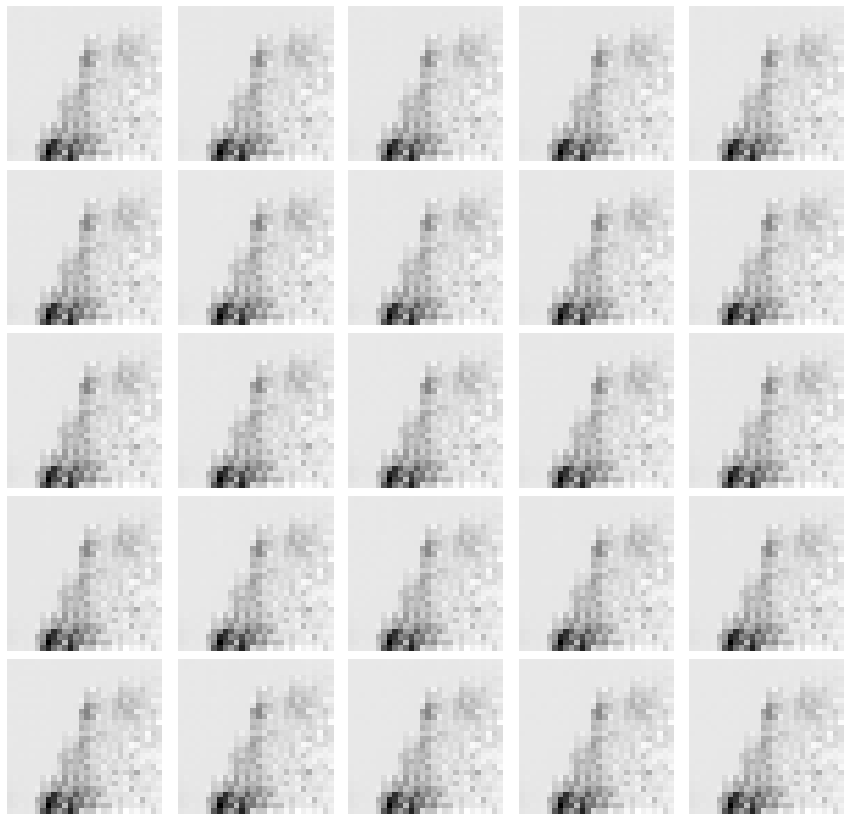

In [31]:
noise = torch.randn(latent_dims*25).to(device)
data = gen(noise.reshape(25, latent_dims))

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):

    ax = axs[i//5, i%5]
    ax.imshow(data[i].permute(1,2,0).cpu().detach().numpy(), cmap='Greys')
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0)

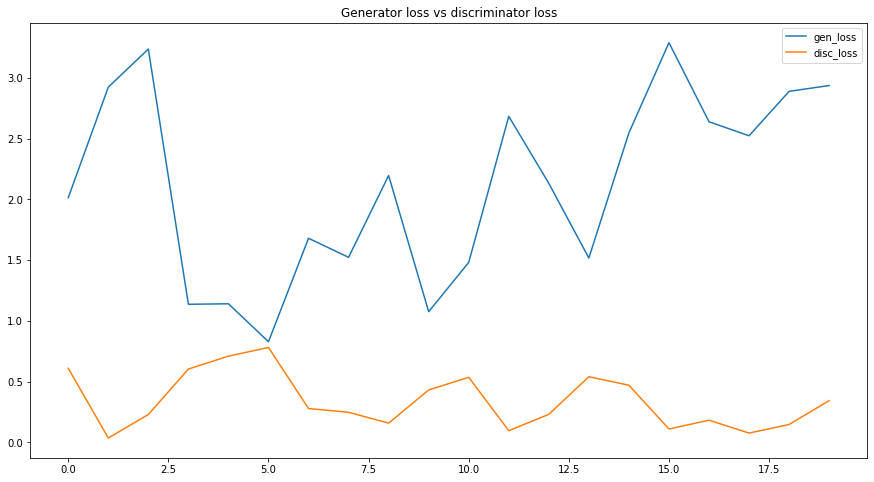

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(dict_loss['gen_loss'])
plt.plot(dict_loss['disc_loss'])
plt.legend(['gen_loss', 'disc_loss'])
plt.title('Generator loss vs discriminator loss')
plt.show()